## Imports

In [1]:
import os

###############################
# FOR FLOYDHUB
###############################

# os.environ["DATAGET_HOME"] = "/data"
# os.environ["MODEL_PATH"] = "/model"

###############################

from scipy.misc import imread
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dataget import data # <== dataget
import tensorflow as tf
from tfinterface.supervised import SupervisedInputs
from plotly import offline as py, graph_objs as go
import utils
from pilot_cli import UdacityEnv



py.init_notebook_mode()

%matplotlib inline

Using TensorFlow backend.


## Obtener Dataset
Utilizando la funcion `data` de `dataget` llamamos el dataset `german-traffic-signs` y ejecutamos el metodo `get` por si acaso aun no tenemos los datos. Podriamos excluir el llamado a `.get()` si ya descargamos los datos desde la consola, sin embargo, `get` no descargara los datos si ya existen por lo tanto no hace daño tenerlo.

In [9]:
# params = Parameters(alpha = 0.04, straight_tol = 0.08, steering_filter = 0.05)

dataset = data(
    "visual-words"
).get(process=False)

df = dataset.training_set.dataframe()
dataset.training_set._dataframe = df[ df["image"].apply(lambda a: a.shape) == (299, 299, 3)]

KeyboardInterrupt: 

In [8]:
df.image.apply(lambda i: i.shape).unique()

array([(299, 299, 3)], dtype=object)

In [3]:
df = next(dataset.training_set.random_batch_dataframe_generator(18000, load_images = False, uniform = True))
groups = df.groupby("angle_class")


bar = go.Bar(
    x = [name for name, group in groups],
    y = groups.size().tolist()
)

hist = go.Histogram(
    x = df.steering,
#     nbinsx = 15
)


py.iplot([bar])
py.iplot([hist])

### Random Batch DataFrame
Para fines de visualizacion, a continuacion vamos a obtener un dataframe de 10 filas con imagenes aleatorias del `training_set` utilizando el metodo `random_batch_dataframe_generator`, este nos devuelve un generador "infinito" por lo cual utilizamos la funcion `next` para obtener solo el primer dataframe.

In [9]:
# obtener 10 imagenes aleatorias (rapido)
df = next(dataset.training_set.random_batch_dataframe_generator(10))

df

steering  throttle  brake     speed  camera  \
12437  0.000000  0.985533    0.0  30.18670       1   
15194 -0.277377  0.985533    0.0  30.18724       2   
16299 -0.124281  0.985533    0.0  30.17926       2   
4460   0.146311  0.985533    0.0  30.18603       0   
6707   0.195719  0.985533    0.0  30.17788       1   
4692   0.320000  0.985533    0.0  30.18665       0   
16052 -0.143418  0.793422    0.0  29.36285       2   
1417   0.320000  0.985533    0.0  30.18698       0   
16025 -0.320000  0.985533    0.0  30.18663       2   
1437   0.320000  0.985533    0.0  30.18696       0   

                                                filename  dir  \
12437  /data/kiwi/pilot-net/.dataget/data/udacity-sel...    1   
15194  /data/kiwi/pilot-net/.dataget/data/udacity-sel...    0   
16299  /data/kiwi/pilot-net/.dataget/data/udacity-sel...    0   
4460   /data/kiwi/pilot-net/.dataget/data/udacity-sel...    2   
6707   /data/kiwi/pilot-net/.dataget/data/udacity-sel...    2   
4692   /data/kiwi/pilot-net/.dataget/data/udacity-sel...    2   
16052  /data/kiwi/pilot-net/.dataget/data/udacity-sel...    0   
1417   /data/kiwi/pilot-net/.dataget/data/udacity-sel...    2   
16025  /data/kiwi/pilot-net/.dataget/data/udacity-sel...    0   
1437   /data/kiwi/pilot-net/.dataget/data/udacity-sel...    2   

                                                   image  
12437  [[[129, 162, 205], [129, 162, 205], [128, 161,...  
15194  [[[119, 148, 190], [119, 148, 190], [119, 148,...  
16299  [[[148, 183, 239], [147, 184, 237], [146, 184,...  
4460   [[[131, 154, 195], [130, 155, 195], [130, 155,...  
6707   [[[192, 173, 140], [185, 169, 135], [170, 155,...  
4692   [[[123, 152, 194], [123, 152, 194], [122, 151,...  
16052  [[[130, 157, 168], [113, 135, 146], [11, 30, 3...  
1417   [[[113, 142, 182], [113, 142, 182], [113, 142,...  
16025  [[[4, 16, 6], [4, 16, 6], [2, 14, 2], [0, 12, ...  
1437   [[[113, 142, 182], [113, 142, 182], [113, 142,...

Como vemos, el dataframe tiene los atributos `filename` que nos indica el nombre del archivo, `class_id` es la clase a la que corresponde la imagen, e `images` el cual contiene la informacion de la imagen representada como arreglos de numpy. Los otros atributos nos dicen la informacion del bounding box pero estos nos son relevantes para la tarea que queremos realizar.

### Visualizacion de las muestras
Para visualizar las muestras iteramos sobre el dataframe y utilizamos la funcion `imshow` de `matplotlib.pyplot` el cual importamos como `plt`.

steering: 0.0, shape: (85, 320, 3), camera: 1


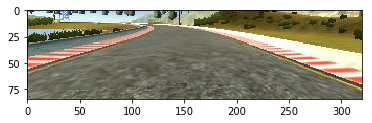

steering: -0.27737716, shape: (85, 320, 3), camera: 2


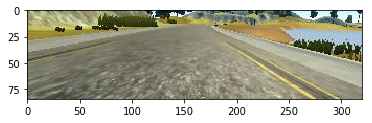

steering: -0.1242806, shape: (85, 320, 3), camera: 2


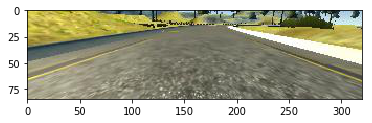

steering: 0.1463105, shape: (85, 320, 3), camera: 0


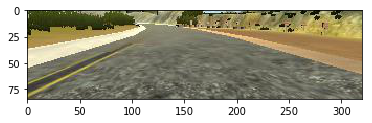

steering: 0.1957194, shape: (85, 320, 3), camera: 1


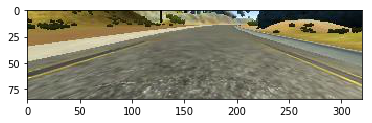

steering: 0.32, shape: (85, 320, 3), camera: 0


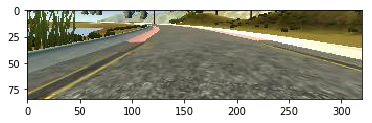

steering: -0.1434177, shape: (85, 320, 3), camera: 2


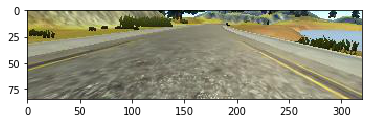

steering: 0.32, shape: (85, 320, 3), camera: 0


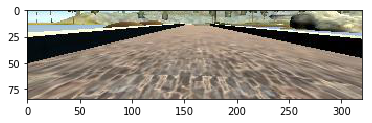

steering: -0.32, shape: (85, 320, 3), camera: 2


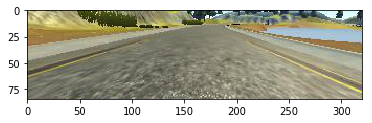

steering: 0.32, shape: (85, 320, 3), camera: 0


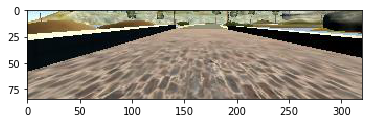

In [10]:
for i, row in df.iterrows():
    img = row.image
    img = utils.process_image(img)
    print("steering: {}, shape: {}, camera: {}".format(row.steering, img.shape, row.camera))
    plt.imshow(img)
    plt.show()

### Numpy Arrays
Para trabajar librarias de Machine Learning usualmente es mas facil obtener los datos como arreglos de numpy, para esto utilizamos los metodos `arrays` o `random_batch_arrays_generator` los cuales nos devuelven una tupla o un generador de tuplas, cada tupla contiene un arreglo `features` con las imagenes y un arreglo `labels` con las clases.

In [6]:
# obtener todas las imagenes (lento)
utils.process_steering(dataset.test_set, params.alpha, params.straight_tol, params.steering_filter)
generator = dataset.test_set.random_batch_arrays_generator(20, extra_features = ["dir"])
generator = utils.process_generator(generator)
data_dict = next(generator)

In [7]:
from model import Model

graph = tf.Graph()
sess = tf.Session(graph=graph)

# inputs
inputs = SupervisedInputs(
    name = network_name + "_inputs",
    graph = graph,
    sess = sess,
    # tensors
    features = dict(shape = (None, params.img_height, params.img_width, 3), dtype = tf.uint8), #, queue = True),
    labels = dict(shape = (None,), dtype = tf.uint8), #queue = True),
)

# create model template
template = Model(
    name = network_name,
    model_path = model_path,
    graph = graph,
    sess = sess,
)

inputs = inputs()
model = template(inputs)

model.initialize(restore = True)

Tensor("nvidia-pilot-net/batch_normalization/cond/Merge:0", shape=(?, 85, 320, 3), dtype=float32)
Tensor("nvidia-pilot-net/Conv2dBatchNorm/Elu:0", shape=(?, 29, 80, 48), dtype=float32)
Tensor("nvidia-pilot-net/Conv2dBatchNorm_1/Elu:0", shape=(?, 29, 40, 96), dtype=float32)
Tensor("nvidia-pilot-net/FireBatchNorm/concat:0", shape=(?, 29, 40, 128), dtype=float32)
Tensor("nvidia-pilot-net/add:0", shape=(?, 29, 40, 128), dtype=float32)
Tensor("nvidia-pilot-net/FireBatchNorm_2/concat:0", shape=(?, 29, 40, 256), dtype=float32)
Tensor("nvidia-pilot-net/max_pooling2d/MaxPool:0", shape=(?, 15, 20, 256), dtype=float32)
Tensor("nvidia-pilot-net/add_1:0", shape=(?, 15, 20, 256), dtype=float32)
Tensor("nvidia-pilot-net/FireBatchNorm_4/concat:0", shape=(?, 15, 20, 384), dtype=float32)
Tensor("nvidia-pilot-net/add_2:0", shape=(?, 15, 20, 384), dtype=float32)
Tensor("nvidia-pilot-net/FireBatchNorm_6/concat:0", shape=(?, 15, 20, 512), dtype=float32)
Tensor("nvidia-pilot-net/max_pooling2d_2/MaxPool:0", s

In [8]:
predictions = model.predict(features = data_dict["features"])
predictions = np.argmax(predictions, axis=1)
predictions = predictions.tolist()
predictions = map(lambda p: ["left", "stright", "right"][p], predictions)
predictions

['left',
 'right',
 'right',
 'left',
 'stright',
 'left',
 'left',
 'stright',
 'stright',
 'left',
 'left',
 'stright',
 'right',
 'right',
 'right',
 'left',
 'left',
 'stright',
 'right',
 'stright']

Label: 0, Prediction: left


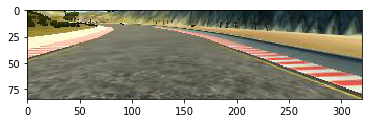

Label: 1, Prediction: right


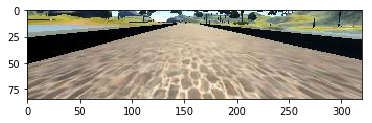

Label: 2, Prediction: right


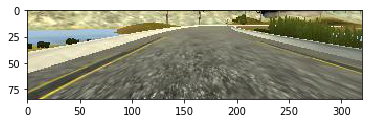

Label: 0, Prediction: left


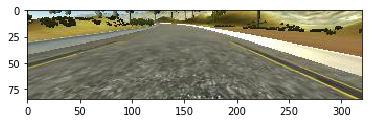

Label: 2, Prediction: stright


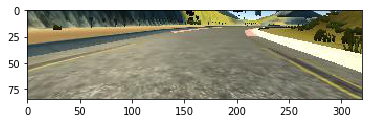

Label: 2, Prediction: left


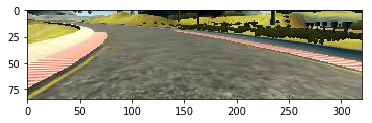

Label: 0, Prediction: left


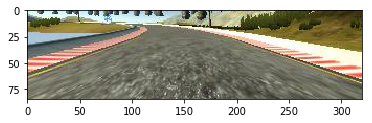

Label: 0, Prediction: stright


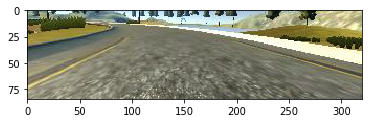

Label: 0, Prediction: stright


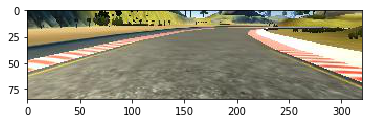

Label: 0, Prediction: left


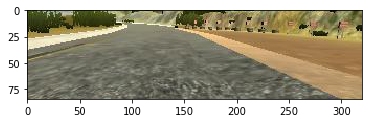

Label: 0, Prediction: left


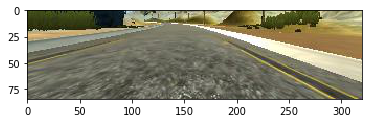

Label: 0, Prediction: stright


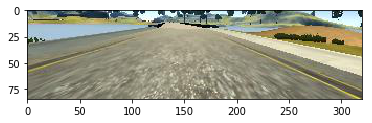

Label: 2, Prediction: right


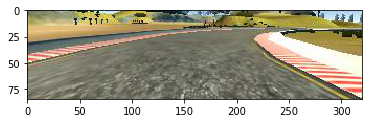

Label: 0, Prediction: right


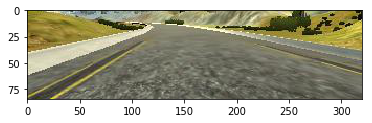

Label: 2, Prediction: right


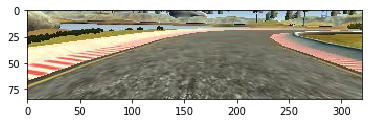

Label: 0, Prediction: left


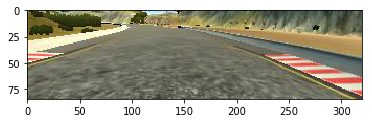

Label: 0, Prediction: left


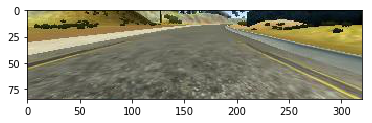

Label: 1, Prediction: stright


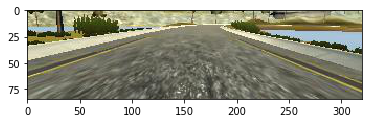

Label: 2, Prediction: right


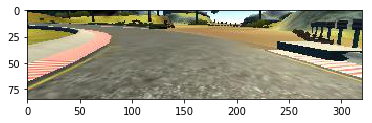

Label: 2, Prediction: stright


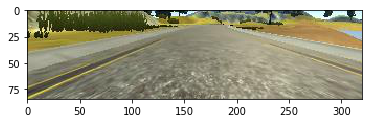

In [9]:
# predictions = model.predict(features = features["image"])

for img, label, preds in zip(data_dict["features"], data_dict["labels"], predictions):
    
    print("Label: {}, Prediction: {}".format(label, preds))
#     f, (ax1, ax2) = plt.subplots(1, 2) #, figsize=(10,10))
    plt.imshow(img)
#     ax1.set_title('True Class: {}'.format(label))
#     ax1.autoscale(False)
    
#     ax2.bar(range(len(top_preds)), preds[top_preds], color="blue")
#     ax2.set_title('Top Predictions'.format(label))
# #     ax2.autoscale(False)
#     xTickMarks = list(map(str, top_preds))
#     xtickNames = ax2.set_xticklabels(xTickMarks)
#     ax2.set_xticks(range(len(top_preds)))
    
#     f.tight_layout()
    
#     print("class {}, top predictions: {}".format(label, top_preds_str))
    plt.show()

In [6]:
angle = 0.02
throttle = 0.01

env = UdacityEnv()
x = env.reset()

print(x)

for x in range(10):
    turn = model.predict(features = [x])
    turn = np.argmax(turn, axis=1)
    turn = turn[0]
    
    action = 0 if turn == 0 else angle if turn == 2 else -angle
    
    x = env.step([action, throttle])

(32449) wsgi starting up on http://0.0.0.0:4567


KeyboardInterrupt: 

(32449) accepted ('127.0.0.1', 34713)
